# **Vehicle Detection and Tracking** 
***
In this project, you will use the computer vision and machine learning tools to identify and track the vehicles on the road. 
I develeoped a pipeline that gets a videao sream recorded from a vehicles front camera and creates a output stream with the located cars positions with rectangles. The result of the pipeline can be seen here <TODO:add video>. 



### 1. Model Construction
We can slipt the model construction section into three parts Data Exploration, Feature Extraction & Selection and Model Training. You can find the whole code in train.py file (it also uses some method in lesson_functions.py) 

#### 1.1 Data Exploration

The labeled data for vehicle and non-vehicle examples to train the classifier to identify vehicles is combination of [**GTI vehicle image database**](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [**KITTI vision benchmark suite**](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. You can see the codes to read the vehicle and non-vehicle data from the files. Note: data is not included to the repository it can be dowload from the links given above.

Number of vehicle data :  8792
Number of non-vehicle data :  8968


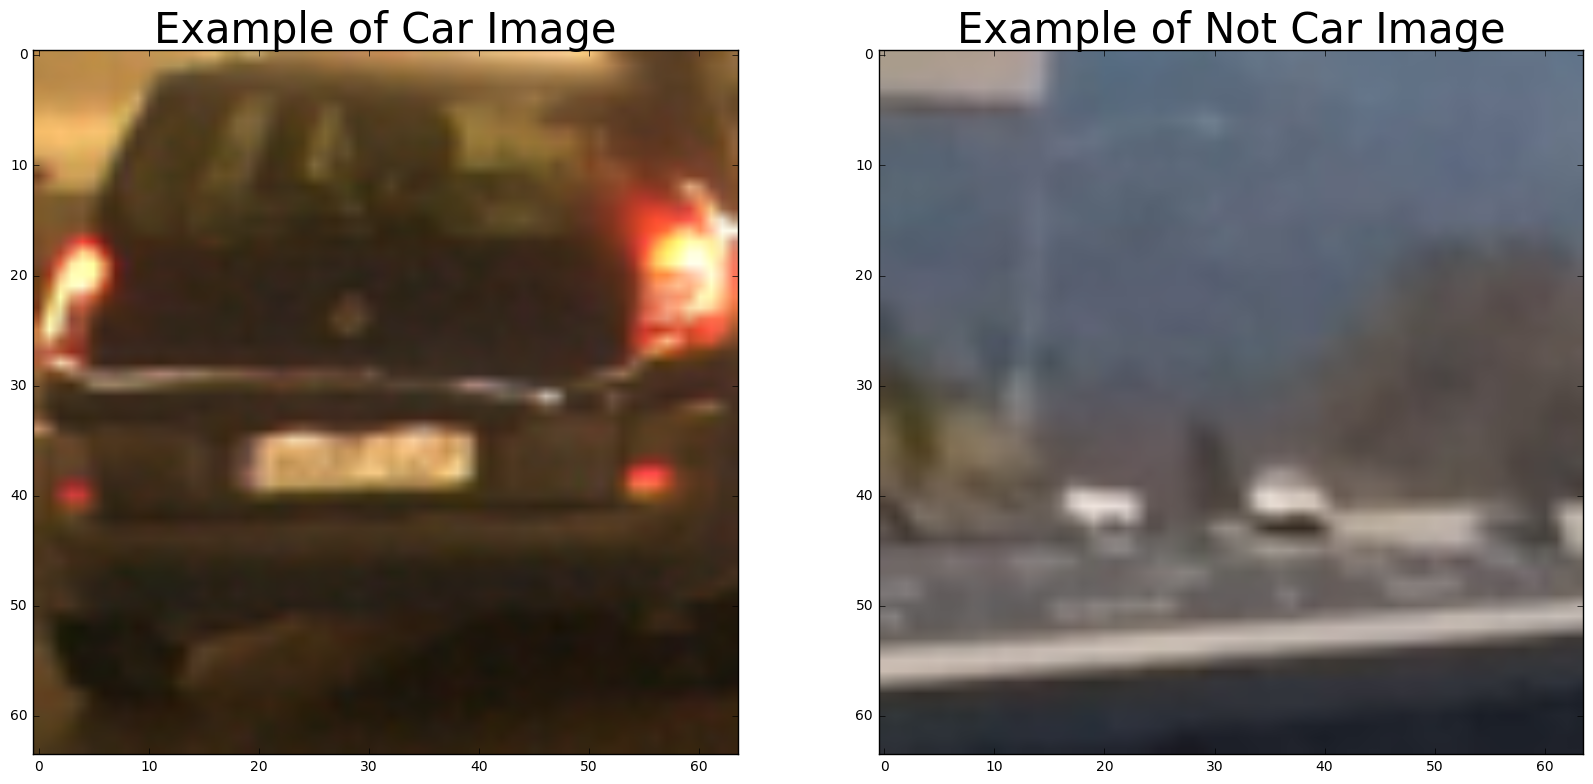

True



In [17]:
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#get directory of the car images
car_images_path = os.getcwd()+'/vehicles'

#load the car images data
cars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(car_images_path)
    for f in files if f.endswith('.png')]

#get directory of the non-car images
non_car_images_path = os.getcwd()+'/non-vehicles'

#load the non-car images data
notcars = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(non_car_images_path)
    for f in files if f.endswith('.png')]

print('Number of vehicle data : ', len(cars))
print('Number of non-vehicle data : ', len(notcars))

# Visualize data example
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread(cars[0]))
ax1.set_title('Example of Car Image', fontsize=30)
ax2.imshow(mpimg.imread(notcars[0]))
ax2.set_title('Example of Not Car Image', fontsize=30)
plt.show()


#### 1.2 Feature Extraction and Selection 

First of all before extracting the image feaures the images is converted to YCrCb from the RGB color space becuase it is seen that it gives better result. To train a good classifier for the given task first we need to extract feature from the data. In this project histograms of colors, spatial binning of color and Histogram of Oriented Gradient (HOG) feaute extraction methods are used to extract the feature. 
In the code bellow you can see the method that is used for feature extraction 

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    :param images: image data
    :param color_space: color space to convert the image
    :param spatial_size: size to reduce resolution
    :param hist_bins: bin size for color histograms
    :param orient: number of orientation bins
    :param pix_per_cell: pixel size of a cell
    :param cell_per_block: number of cells in each block
    :param hog_channel: channel to be used for hog  
    :param spatial_feat: flag to check if spatial features will be used
    :param hist_feat: flag to check if color histogram features will be used
    :param hog_feat: flag to check if hog features will be used
    :return: combined feature vector
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


###### 1.2.1 Spatial Binning of Color
Firstly, we can use raw pixel values in our feature vector to search vehicles. However to include raw pixel values from all 3 channel will put a huge burden on the system. Therefore we decrease the resolution and we see that it is still a good information source Therefore cv2.resize() function is used to decrease the resolution to 16x16 then we applied the ravel() function on resized image to get one dimensional feature vector. We used the bin_spatial method from the lesson fuction with spatial_size equals 16. Finally we append the new features to the feature vector.
          
    
    if spatial_feat == True:
       spatial_features = bin_spatial(feature_image, size=spatial_size)
       file_features.append(spatial_features)

    #Define a function to compute binned color features
    def bin_spatial(img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel()
        #Return the feature vector
        return features

##### 1.2.2 Histograms of Color 
Color can be a good indicator to identify vehicles and non vehicles images. For that purpose first we calculate histograms of pixel intensity of all 3 channels with histogram bin size 16 and add that histograms to our feature vector. Finally we append the new features to the feature vector.

    if hist_feat == True:
        # Apply color_hist() 
        hist_features = color_hist(feature_image)
        file_features.append(hist_features)

    #Define a function to compute color histogram features
    #NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
        #Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        #Return the individual histograms, bin_centers and feature vector
        return hist_features

###### 1.2.3 Histogram of Oriented Gradients (HOG) 
Histogram of Oriented Gradients is commonly used feature descriptor in image processing for object detection. To extract the HOG features 
**hog** method is used form skimage package to extract hog features. First I tried the same parametes as in the lesson they were ok but then the parameters were tuned according to test results. How the parameters have been choosen will be explaine din the Model Training Section. 

        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

    #Define a function to return HOG features and visualization
    def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                         vis=False, feature_vec=True):
        #Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=True,
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        #Otherwise call with one output
        else:
            features = hog(img, orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=True,
                           visualise=vis, feature_vector=feature_vec)
            return features
            
 ##### 1.3 Feature Normalization
 After extracting the feautures we need to normalize the feature vector as it caontains different types of features with different scales. Thus we use StandardScaler() from sklearn package to scale the final feature vector. 
 
        #combine and convert the type of the feture vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
##### 1.4 Model Training

Support Vector Machine (SVM) to classification of the car and not car images. From sklearn package we use LinearSVC class to model the Linear Support Vector Machine as our classifier. The method for traing and testing shown in the cell bellow. First we create the car and not cars features vector then normalized the combined feature vectors then we split the data for traiing and testing. We used the 80% of the data for traing and rest for to test. 

Firstly, we used the same parameters as we used in the lesson for the feature extraction and traing. So we created a feature vector with size 4932 and it took 45.18 to traing the linear svc model and it resulted with 0.9704 testing accuracy. After that we tried to change the parameters one by one the first one we begun with was color space. Firsly  I chnage the hog channel to all so it uses the all three channel then I tried  all color spaces with the same parameters and the YCrCb color space with all channles the same parametes above gave the best result. (and YUV was the worst one the model that trained with YUV color space never found a car.) However, with using all chanlles the feature vector traing and searching/detection time (this is the most important one because we want to search and detect the cars in real time) incereased. After that we decreased the spatial size to (16, 16) and histogram bins to 16 and orient to 8 in order to decrease the feature vector and search time. After all experiments with the parametes I found the best parmaters are given bellow. You can see the codes and the results of the best found parameters on two cell bellow. 

Parameters: {'spatial_size': (16, 16), 'hog_channel': 'ALL', 'cell_per_block': 2, 'pix_per_cell': 8, 'hog_feat': True, 'hist_feat': True, 'orient': 8, 'spatial_feat': True, 'color_space': 'YCrCb', 'hist_bins': 16}



In [19]:
def train_test_model(parameters,do_training=False,model_path = 'models/linear_svc.p', image = None):
    '''
    Method to train and test the model
    :param parameters: a dict that contains traing parameters (hog features, bin size, spatial szie etc.)
    :param do_training: a flag if we want to do training
    :param model_path: path to save model in
    :param image:  image file to test the model
    :return: image contains the boxes on the car position
    '''

    #cehck the model files exist if not do trainig or if the do_training is True restart train'ng the ex'st'ng model
    if not os.path.isfile(model_path) or do_training:
        print('Train the model.')
        t = time.time()
        # Extract the car features and create the feature vector
        car_features = extract_features(cars, color_space=color_space,
                                        spatial_size=spatial_size, hist_bins=hist_bins,
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, hog_feat=hog_feat)

        # Extract the notcar features and create the feature vector
        notcar_features = extract_features(notcars, color_space=color_space,
                                           spatial_size=spatial_size, hist_bins=hist_bins,
                                           orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block,
                                           hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat)

        #combine and convert the type of the feture vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Parameters:',parameters)
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC
        svc = LinearSVC()
        # Check the training time for the SVC

        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2 - t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        with open(model_path, 'wb') as model_file:
            pickle.dump({'svc': svc,'X_scaler': X_scaler,'parameters': parameters},model_file,pickle.HIGHEST_PROTOCOL)
        print('Model has saved to ' ,model_path)
    else:
        with open(model_path, 'rb') as model_file:
            model = pickle.load(model_file)
            svc = model['svc']
            X_scaler = model['X_scaler']
            parameters = model['parameters']
    if image is not None:
        draw_image = np.copy(image)
        windows = []
        create_search_windows(windows, image)
        print('windows size : ', len(windows))

        image = image.astype(np.float32) / 255
        t = time.time()
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=parameters['color_space'],
                                        spatial_size=parameters['spatial_size'], hist_bins=parameters['hist_bins'],
                                        orient=parameters['orient'], pix_per_cell=parameters['pix_per_cell'],
                                        cell_per_block=parameters['cell_per_block'],
                                        hog_channel=parameters['hog_channel'], spatial_feat=parameters['spatial_feat'],
                                        hist_feat=parameters['hist_feat'], hog_feat=parameters['hog_feat'])

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        t2 = time.time()
        print(round(t2 - t, 2), 'Seconds to search_windows ...')
        return window_img


In [21]:

color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 690]  # Min and max in y to search in slide_window()



parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }



RGB_model_path = 'models/RGB_linear_svc.p'
#taing the model with above parameters and save it to the disk 
print('--------------------------------------------------------------')
print("Start traing for RGB. ")
train_test_model(parameters,do_training=True, model_path=RGB_model_path)
print('Traing completed for RGB. ')
print('--------------------------------------------------------------')
print()
#cahnge the parametes and do traing again
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 690]  # Min and max in y to search in slide_window()



parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 690]  # Min and max in y to search in slide_window()



parameters = { 'color_space' : color_space,
               'orient': orient ,
               'pix_per_cell': pix_per_cell,
               'cell_per_block':cell_per_block,
               'hog_channel':hog_channel,
               'hist_bins':hist_bins,
               'spatial_feat':spatial_feat,
               'hist_feat':hist_feat,
               'hog_feat':hog_feat,
               'spatial_size':spatial_size }



YCrCb_model_path = 'models/YCrCb_linear_svc.p'
#taing the model with above parameters and save it to the disk 
print('--------------------------------------------------------------')
print("Start traing for YCrCb. ")
train_test_model(parameters,do_training=True, model_path=YCrCb_model_path)
print('Traing completed for YCrCb. ')
print('--------------------------------------------------------------')

--------------------------------------------------------------
Start traing for RGB. 
Train the model.
Parameters: {'spatial_size': (32, 32), 'hog_channel': 0, 'cell_per_block': 2, 'pix_per_cell': 8, 'hog_feat': True, 'hist_feat': True, 'orient': 9, 'spatial_feat': True, 'color_space': 'RGB', 'hist_bins': 32}
Feature vector length: 4932
45.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9704
Model has saved to  models/RGB_linear_svc.p
Traing completed for RGB. 
--------------------------------------------------------------

--------------------------------------------------------------
Start traing for YCrCb. 
Train the model.
Parameters: {'spatial_size': (16, 16), 'hog_channel': 'ALL', 'cell_per_block': 2, 'pix_per_cell': 8, 'hog_feat': True, 'hist_feat': True, 'orient': 8, 'spatial_feat': True, 'color_space': 'YCrCb', 'hist_bins': 16}
Feature vector length: 5520
75.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
Model has saved to  models/YCrCb_linear_svc.p
Traing comp

windows size :  245
0.35 Seconds to search_windows ...
0.36 procesing time for RGB
windows size :  245
0.88 Seconds to search_windows ...
0.89 procesing time for YCrCb.


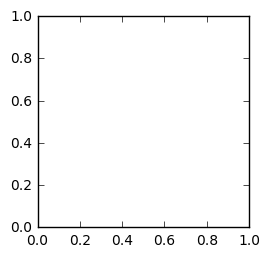

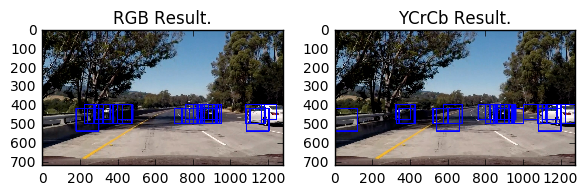

windows size :  245
0.35 Seconds to search_windows ...
0.36 procesing time for RGB
windows size :  245
1.02 Seconds to search_windows ...
1.02 procesing time for YCrCb.


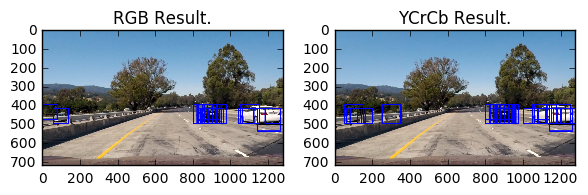

windows size :  245
0.35 Seconds to search_windows ...
0.35 procesing time for RGB
windows size :  245
0.88 Seconds to search_windows ...
0.88 procesing time for YCrCb.


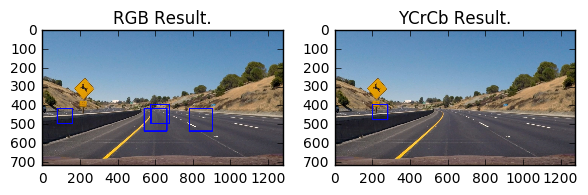

windows size :  245
0.37 Seconds to search_windows ...
0.37 procesing time for RGB
windows size :  245
0.86 Seconds to search_windows ...
0.87 procesing time for YCrCb.


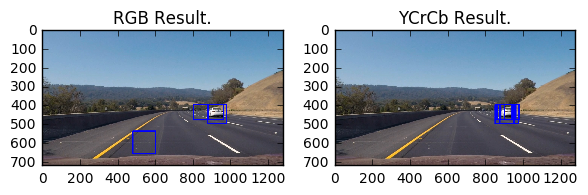

windows size :  245
0.35 Seconds to search_windows ...
0.36 procesing time for RGB
windows size :  245
0.86 Seconds to search_windows ...
0.87 procesing time for YCrCb.


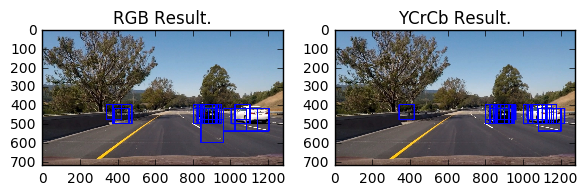

windows size :  245
0.36 Seconds to search_windows ...
0.36 procesing time for RGB
windows size :  245
0.9 Seconds to search_windows ...
0.9 procesing time for YCrCb.


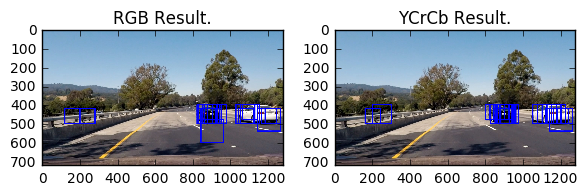

In [24]:
import glob
images = glob.glob('test_images/*.jpg')
for image_path in images:
    image = mpimg.imread(image_path)
    
    
    t = time.time()
    RGB_result = train_test_model(parameters,do_training=False, model_path=RGB_model_path,image=image)
    t2 = time.time()
    print(round(t2 - t, 2), 'procesing time for RGB')
    
    t = time.time()
    YCrCb_result = train_test_model(parameters,do_training=False, model_path=YCrCb_model_path,image=image)
    t2 = time.time()
    print(round(t2 - t, 2), 'procesing time for YCrCb.')
    

    
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(RGB_result)
    plt.title('RGB Result.')
    plt.subplot(122)
    plt.imshow(YCrCb_result)
    plt.title('YCrCb Result.')
    fig.tight_layout()
    plt.show()

##### Sliding Window Search
Vehicle can be certain location and size on the recorded frame rom the fron camera of the car. We need a method to search the cars on those position for that purpose we created windows where the cars can be in so that cars can be found half bottom on the frame (the upper buttom is mostly sky or something else) and car sizes (on the image in pixel) increase on the buttom. Hence we created 4 different sizes of square (80,100,120 and 160) windows according to y coordinates. Also we set the xy overlap of the 80 and 100 size widnows to 0.75 because we want to move overlap to don't miss the car (since it is higly possible to miss the car with the low overlaping and small windows). for the 120 and 160 size windows we set the xy overlap to 0.5 in order to not increase the windows size (it will eventually increse the procesing time and decrease the fps). In the end you can see the all windows on the example imga ein the cell bellow there are total 245 windows to search. 

In [ ]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255
def create_search_windows(search_windows,image):
    '''
    Method to create search windows list
    :param search_windows: list to append the search windows
    :param image: image to be search on
    :return: None
    '''
    search_windows += slide_window(image.shape, x_start_stop=[None,None],
                                        y_start_stop=[400, 500],
                                        xy_window=(80, 80), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[400, 500],
                                        xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[420, 660],
                                        xy_window=(120, 120), xy_overlap=(0.5, 0.5))
    search_windows += slide_window(image.shape, x_start_stop=[None, None],
                                        y_start_stop=[500, 690],
                                        xy_window=(160, 160), xy_overlap=(0.5, 0.5))

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


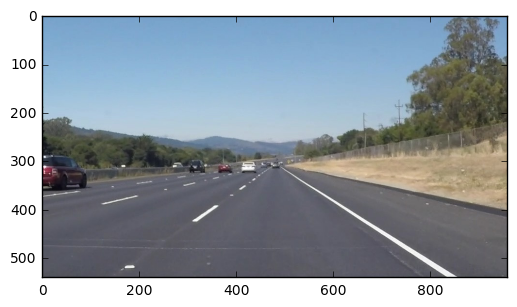

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [117]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slopes = []
    right_slopes = []
    left_lines = []
    right_lines = []
    l_y1 = []
    l_y2 = []
    l_x1 = []
    l_x2 = []
    y_min = img.shape[0]
    y_max = img.shape[0]
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope < 0:
                    l_y1.append(y1)
                    l_y2.append(y2)
                    l_x1.append(x1)
                    l_x2.append(x2)
                    left_slopes.append(slope)
                    left_lines.append(line) 
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    y_min = min(l_y1 + l_y2)
    y_max = max(l_y1 + l_y2)
    print('y_min = ',y_min ,' y_max =  ',y_max  )
    left_average = np.array(left_lines)
    left_mean = np.mean(left_average,axis=0)
    print(left_lines)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def select_color(img):
    """
    Returns an image with only white and yellow colors and black out the other areas
    """
    # define range of yellow color in RGB
    lower_yellow = np.array([255,255,130])
    upper_yellow = np.array([150,100,0])
    yellow_image = cv2.inRange(img, upper_yellow, lower_yellow)
    lower_white = np.array([255,255,255])
    upper_white = np.array([150,150,150])
    white_image = cv2.inRange(img, upper_white,lower_white)
    combined_color = cv2.bitwise_or(yellow_image,white_image)
    res = cv2.bitwise_and(img,img, mask= combined_color)
    return res

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [118]:
import os
os.listdir("test_images/")

['chalenge_1.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solid_yellow.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [119]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [120]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    color_selected = select_color(image)
    
    #Read in and grayscale the image
    gray = grayscale(color_selected)
    # Define a kernel size and apply Gaussian smoothing
    
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray,low_threshold,high_threshold)
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(180,imshape[0]),(450, 310), (500, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    vert = np.array([[(200,imshape[0]),(250, 480), (650, 480), (imshape[1]-100,imshape[0])]], dtype=np.int32)
    masked_edges = cv2.fillPoly(masked_edges,vert,0)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 80 #minimum number of pixels making up a line
    max_line_gap = 30   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(lines, cmap='gray')
    weighted_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return weighted_image

whiteCarLaneSwitch.jpg
(540, 960, 3)
y_min =  310  y_max =   508
[array([[273, 478, 488, 310]], dtype=int32), array([[217, 508, 396, 373]], dtype=int32), array([[296, 451, 477, 315]], dtype=int32), array([[273, 479, 481, 316]], dtype=int32), array([[325, 431, 478, 316]], dtype=int32), array([[369, 399, 479, 316]], dtype=int32), array([[378, 387, 489, 312]], dtype=int32), array([[312, 435, 416, 359]], dtype=int32)]


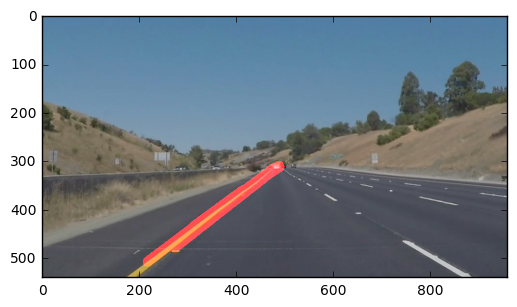

In [121]:
file_list = os.listdir("test_images")
i=1
#for file_name in file_list:
while i==1:
    plt.figure(i)
    print(file_name)
   
    image_file = mpimg.imread("test_images/" + file_name)
    print(image_file.shape)
    #print(image_file[539][959])
    processed_image = process_image(image_file)
    plt.imshow(processed_image)
    i = i+1


### Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(lambda clip1: process_image(clip1, 1)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lambda image: process_image(image, param))
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))